In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
# Figure out how to import regularizers
###
import tensorflow.keras.utils as ku
import numpy as np

In [ ]:
tokenizer = Tokenizer()

# DOWNLOAD DATA AND UPLOAD TO tmp folder
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
data = open('sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

--2022-04-20 08:58:17--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 64.233.183.128, 173.194.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2022-04-20 08:58:17 (127 MB/s) - ‘sonnets.txt’ saved [93578/93578]



In [ ]:
# Pick an optimizer
import tensorflow as tf
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(400)))
model.add(Dense(800, activation='elu'))
model.add(Dense(1000, activation='elu'))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
print(model.summary())

history = model.fit(predictors, label, epochs=100, verbose=1)
acc = history.history['accuracy']
loss = history.history['loss']
print(acc, loss)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           321100    
                                                                 
 bidirectional (Bidirectiona  (None, 10, 256)          234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 512)          1050624   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 512)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 800)              2

In [ ]:
seed_text = "you are"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
#predicted = model.predict_classes(token_list, verbose=0)
predict_x=model.predict(token_list)
classes_x=np.argmax(predict_x,axis=1)
output_word = ""
for word, index in tokenizer.word_index.items():
    if index == classes_x:
        output_word = word
        break
seed_text += " " + output_word
print(seed_text)


you are my


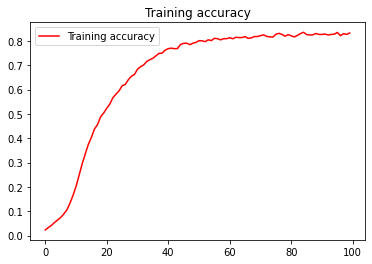

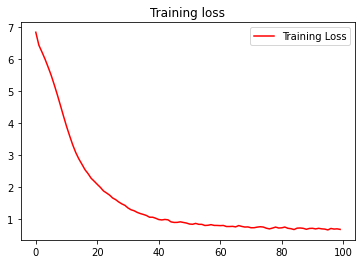

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
import matplotlib.pyplot as plt
acc = history.history['accuracy']  # Your Code Here
loss = history.history['loss']  # Your Code Here

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')

plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
model.save('sarcasm.h5')